# Xiaoxuan Wang
# HW 7

In [6]:
import numpy as np
import math
from scipy.sparse import diags
import matplotlib.pyplot as plt


In [7]:
class CN:
    def __init__(self, CallFlag='C',Type='European', S0=100, K=100, T=10, vol=0.5, r=0.0001,div=0,plot=False):
        self.CallFlag=CallFlag
        self.S0=S0
        self.K=K
        self.T=T
        self.vol=vol
        self.r=r
        self.div=div
        self.Type=Type
        self.plot=plot
        
    def OP(self):
        mu = (self.r-self.div-0.5*self.vol*self.vol)
        # range x in [-x_max, x_max]
        x_max = self.vol*np.sqrt(self.T)*5  
        #number of steps along x
        N = 526 #so that X has 0.18, which approximately equals ln(1.2)
        dx = 2*x_max/N
        # grid along x dimension:
        X = np.linspace(-x_max,x_max,N+1)
        #number of time steps
        J = 600 #multiple of 12 for Bermuda
        dt = self.T/J
        # grid along time dimension:
        d=self.vol*self.vol/(4*dx*dx)-mu/(4*dx)
        c=1/dt-self.r/2-0.5*self.vol*self.vol/(dx*dx)
        cc=1/dt+self.r/2+0.5*self.vol*self.vol/(dx*dx)
        u=self.vol*self.vol/(4*dx*dx)+mu/(4*dx)
        A = cc*np.eye(N+1) -u*np.eye(N+1,k=1) -d*np.eye(N+1,k=-1)
        B = c*np.eye(N+1) + u*np.eye(N+1,k=1) +d*np.eye(N+1,k=-1)
        Ainv = np.linalg.inv(A)
        C=Ainv.dot(B)
        cut = int(N/4)
        n_mid=int(N/2)
        
        if self.Type=='European':
            if self.CallFlag=='C':
                V = np.clip(self.S0*np.exp(X)-self.K,0,1e10)
                for j in range(J):
                    V = C.dot(V)
                    V[0] = 0
                    V[N] = self.S0*np.exp(x_max) - self.K*np.exp(-self.r*j*dt)
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])

            else: #European Put
                V = np.clip(self.K-self.S0*np.exp(X),0,1e10)
                for j in range(J):
                    V = C.dot(V)
                    V[0] = self.K*np.exp(-self.r*j*dt)
                    V[N] = 0
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
            
        elif self.Type=='American': #American
            if self.CallFlag=='C':
                V0 = np.clip(self.S0*np.exp(X)-self.K,0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = C.dot(V)
                    # apply early exercise boundary conditions: 
                    V = np.where(V<V0, V0, V)
                    V[0] = 0
                    V[N] = self.S0*np.exp(x_max) - self.K*np.exp(-self.r*j*dt)
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
            else: #American Put
                V0 = np.clip(self.K-self.S0*np.exp(X),0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = C.dot(V)
                    # apply early exercise boundary conditions: 
                    V = np.where(V<V0, V0, V)
                    V[0] = self.K*np.exp(-self.r*j*dt)
                    V[N] = 0
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
        elif self.Type=='Bermuda':
            if self.CallFlag=='C':
                V0 = np.clip(self.S0*np.exp(X)-self.K,0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = C.dot(V)
                    #early exercise conditions: j=49/99/.../599 indicating 12 months
                    if (j+1)%50==0: V = np.where(V<V0, V0, V)
                    V[0] = 0
                    V[N] = self.S0*np.exp(x_max) - self.K*np.exp(-self.r*j*dt)
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
            else: #Bermuda Put
                V0 = np.clip(self.K-self.S0*np.exp(X),0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = C.dot(V)
                    # apply early exercise boundary conditions: 
                    if (j+1)%50==0: V = np.where(V<V0, V0, V)
                    V[0] = self.K*np.exp(-self.r*j*dt) 
                    V[N] = 0
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                
        elif self.Type=='Knock-out European Barrier':
            H=120
            if self.CallFlag=='C': # x=ln1.2 when S=120
                V0 = np.clip(self.S0*np.exp(X)-self.K,0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = C.dot(V)
                    # apply early exercise conditions:
                    V = np.where(X<math.log(H/self.S0),V,0)
                    V[0] = 0
                    V[N] = self.S0*np.exp(x_max) - self.K*np.exp(-self.r*j*dt)
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
            
            elif self.CallFlag=='P': #Knock-out put
                V0 = np.clip(self.K-self.S0*np.exp(X),0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = C.dot(V)
                    # apply early exercise conditions: 
                    V = np.where(X<math.log(H/self.S0),V,0)
                    V[0] = self.K*np.exp(-self.r*j*dt)
                    V[N] = 0
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
            else: #double knock-out put
                V0 = np.clip(self.K-self.S0*np.exp(X),0,1e10)
                V = V0.copy()
                for j in range(J):
                    V = C.dot(V)
                    # apply early exercise conditions: 
                    V = np.where(X<math.log(H/self.S0),V,0)
                    V = np.where(X>math.log(80/self.S0),V,0)
                    V[0] = self.K*np.exp(-self.r*j*dt)
                    V[N] = 0
                    if self.plot==True and j%50==0: plt.plot(self.S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
        else:    print('not a option type')
        return V[n_mid]
        
    
    def Delta(self):
        a=self.OP()
        keep_S0=self.S0
        self.S0=self.S0+1
        b=self.OP()
        self.S0=keep_S0
        return b-a
        
    def Gamma(self):
        a=self.OP()
        keep_S0=self.S0
        self.S0=self.S0+1
        b=self.OP()
        self.S0=self.S0+1
        c=self.OP()
        d1=b-a
        d2=c-b
        self.S0=keep_S0
        return d2-d1
    
    def Theta(self):
        a=self.OP()
        keep_T=self.T
        self.T=self.T-0.001
        b=self.OP()
        self.T=keep_T
        return (b-a)/0.001

(15.906010865189558,
 0.5829511613457541,
 0.00896301168376823,
 -7.735154592335647)

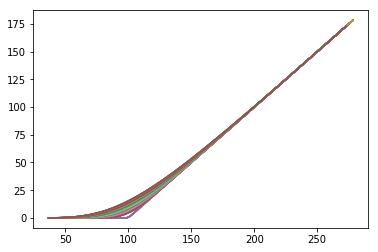

In [10]:
(S0, K, T, vol, r, d) = (100, 100, 1, 0.4, 0.025, 0.0175)
Ber_Call=CN(CallFlag='C',Type='Bermuda', S0=S0, K=K, T=T, vol=vol, r=r,div=d, plot=True)
Ber_Call.OP(),Ber_Call.Delta(),Ber_Call.Gamma(),Ber_Call.Theta()

(15.255314836723251,
 -0.40540863748396205,
 0.009120693893997611,
 -7.124736073976123)

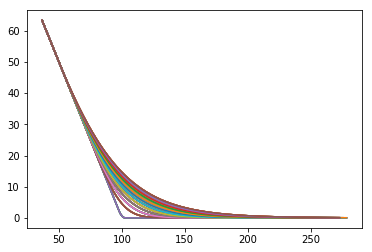

In [11]:
Ber_Put=CN(CallFlag='P',Type='Bermuda', S0=S0, K=K, T=T, vol=vol, r=r, div=d, plot=True)
Ber_Put.OP(), Ber_Put.Delta(), Ber_Put.Gamma(), Ber_Put.Theta()

(0.021733576132188098,
 -0.0005435201055965094,
 -8.59074880757843e-05,
 -0.03628929740565057)

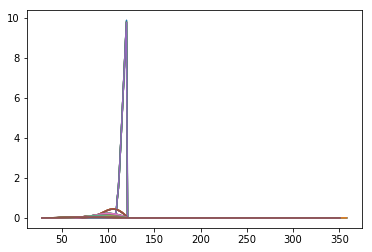

In [13]:
(S0, K, T, vol, r, d) = (100, 110, 1, 0.5, 0.025, 0.0175)
Up_Call=CN('C','Knock-out European Barrier',S0,K,T,vol,r,d,plot=True)
Up_Call.OP(), Up_Call.Delta(), Up_Call.Gamma(), Up_Call.Theta()

(9.82582558321487,
 -0.45750384354494855,
 0.000545166207778891,
 -5.72795794417047)

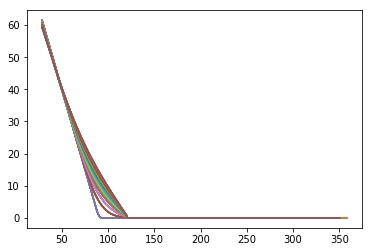

In [14]:
(S0, K, T, vol, r, d) = (100, 90, 1, 0.5, 0.025, 0.0175)
Up_Put=CN('P','Knock-out European Barrier',S0,K,T,vol,r,d,plot=True)
Up_Put.OP(), Up_Put.Delta(), Up_Put.Gamma(), Up_Put.Theta()


(0.0014361212770304652,
 -2.365343399217965e-05,
 -3.9061941252323e-06,
 -0.0021949805373356387)

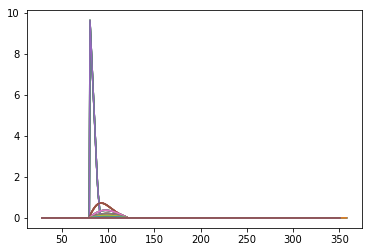

In [18]:
(S0, K, T, vol, r, d) = (100, 90, 1, 0.5, 0.025, 0.0175)
double_Put=CN('double put','Knock-out European Barrier',S0,K,T,vol,r,d, plot=True)
double_Put.OP(), double_Put.Delta(), double_Put.Gamma(), double_Put.Theta()

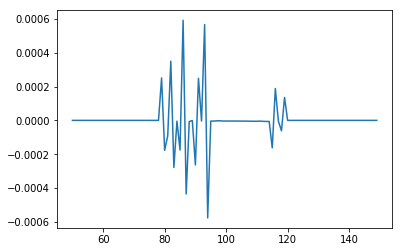

In [17]:
(K, T, vol, r, d) = (90, 1, 0.5, 0.025, 0.0175)
prices=[i for i in range(50,150)]
Gammas=list()
for p in prices:
    temp=CN('double put','Knock-out European Barrier',p, K, T, vol, r,d)
    Gammas.append(temp.Gamma())
    
plt.plot(prices,Gammas)